In [1]:
%load_ext autoreload

In [12]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, lfilter
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from multiproc import compute_VAR
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, save, to_string

In [3]:
## propofolPuffTone
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160105-01'
# session = 'Mary-Anesthesia-20160916-02'
# session = 'MrJones-Anesthesia-20160301-01'
# session = 'MrJones-Anesthesia-20160113-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## Load Neural Data

In [4]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [5]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 132.35 seconds)


# Bandpass Filter

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
lfp_filtered = np.zeros(lfp.shape)

In [11]:
for unit_num in tqdm(range(lfp.shape[1])):
    lfp_filtered[:, unit_num] = butter_bandpass_filter(lfp[:, unit_num], 0.5, 100, 1/dt)

  0%|          | 0/253 [00:00<?, ?it/s]

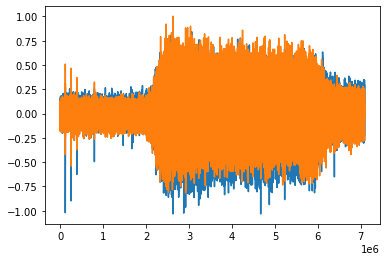

In [14]:
plt.plot(lfp[:, 0])
plt.plot(lfp_filtered[:, 0])
plt.show()

# Compute VAR

In [16]:
area = 'vlPFC'
window = 10
stride = 10

In [21]:
unit_indices = np.where(electrode_info['area'] == area)[0]
num_windows = int(np.floor((T-int(window/dt))/int(stride/dt))+1)
VAR_results = []
for i in tqdm(range(num_windows)):
    window_data = lfp_filtered[int(stride/dt)*i:int(stride/dt)*i + int(window/dt), unit_indices]
    results_dict = compute_VAR(window_data, unit_indices)
    results_dict['start_time'] = i*stride
    results_dict['end_time'] = i*stride + window
    results_dict['start_ind'] = i*int(stride/dt)
    results_dict['end_ind'] = i*int(stride/dt) + int(window/dt)
    
    VAR_results.append(results_dict)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/708 [00:00<?, ?it/s]

In [29]:
result_path = get_result_path("/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR", session, window)
VAR_results_2 = load(os.path.join(result_path, 'vlPFC'))

In [32]:
unit_indices = np.where(electrode_info['area'] == area)[0]
num_windows = int(np.floor((T-int(window/dt))/int(stride/dt))+1)
VAR_results_3 = []
for i in tqdm(range(num_windows)):
    window_data = butter_bandpass_filter(lfp[int(stride/dt)*i:int(stride/dt)*i + int(window/dt), unit_indices], 0.5, 100, 1/dt)
    results_dict = compute_VAR(window_data, unit_indices)
    results_dict['start_time'] = i*stride
    results_dict['end_time'] = i*stride + window
    results_dict['start_ind'] = i*int(stride/dt)
    results_dict['end_ind'] = i*int(stride/dt) + int(window/dt)
    
    VAR_results_3.append(results_dict)
VAR_results_3 = pd.DataFrame(VAR_results)

  0%|          | 0/708 [00:00<?, ?it/s]

In [39]:
unit_indices = np.where(electrode_info['area'] == area)[0]
num_windows = int(np.floor((T-int(window/dt))/int(stride/dt))+1)
VAR_results_4 = []
for i in tqdm(range(num_windows)):
    window_data = butter_bandpass_filter(lfp[int(stride/dt)*i:int(stride/dt)*i + int(window/dt), unit_indices], 0, 250, 1/dt)
    results_dict = compute_VAR(window_data, unit_indices)
    results_dict['start_time'] = i*stride
    results_dict['end_time'] = i*stride + window
    results_dict['start_ind'] = i*int(stride/dt)
    results_dict['end_ind'] = i*int(stride/dt) + int(window/dt)
    
    VAR_results_4.append(results_dict)
VAR_results_4 = pd.DataFrame(VAR_results)

  0%|          | 0/708 [00:00<?, ?it/s]

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=1000.0 -> fs/2=500.0)

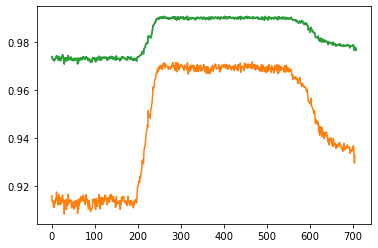

In [33]:
plt.plot(VAR_results.criticality_inds.apply(lambda x: x.mean()), )
plt.plot(VAR_results_2.criticality_inds.apply(lambda x: x.mean()))
plt.plot(VAR_results_3.criticality_inds.apply(lambda x: x.mean()))
plt.show()